In [115]:
! pip3 install --upgrade emcee corner pytorch-lightning tqdm nflows scipy zuko

676848.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner
import zuko

# Simulation-based (likelihood-free) inference
Originally by **Siddharth Mishra-Sharma**.
Updated by **Jessie Micallef** ([jessiem@mit.edu](mailto:jessiem@mit.edu))

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jessimic/sbi-tutorial/blob/main/tutorial.ipynb)

## 1. Introduction

Simulation-based inference (SBI) is a powerful class of methods for performing inference in settings where the likelihood is computationally intractible or challenging, but simulations can be realized via forward modeling. 

In this lecture we will
- Introduce the concept of an implicit likelihood, and how to leverage it to perform inference;
- Build up two common modern _neural_ SBI techniques: neural likelihood-ratio estimation (NRE) and neural posterior estimation (NPE);
- Introduce the concept of statistical coverage testing and calibration.

As examples, we will look at a simple Gaussian-signal-on-power-law-background ("bump hunt"), where the likelihood is tractable, and a more complicated example of inferring a distribution of point sources, where the likelihood is computationally difficult. We will emphasize what it means for a likelihood to be computationally challenging and where the advantages of SBI come in.

<img src=./assets/likelihood.png alt= “” width=800>
<img src=./assets/sbi.png alt= “” width=800>


# 1.1 Simple bump-on-power-law example

As an initial example, we'll look at a singal and background example. Consider a Gaussian signal ($x_s$), which we can parameterized by some [amplitude ($A_s$), mean location ($\mu_s$), standard deviation ($\sigma_s$)]. This signal will be on top of the background ($x_b$), represented by a power law parameterized as [amplitude ($A_b$), power-law exponent ($n_b$)].
$$x_s = A_s\,\exp^{-(y - \mu_s)^2 / 2\sigma_s^2}$$
$$ x_b = A_b\,y^{n_b}$$
$$x \sim \mathrm{Pois}(x_b + x_s)$$

Text(0, 0.5, 'counts (stacked)')

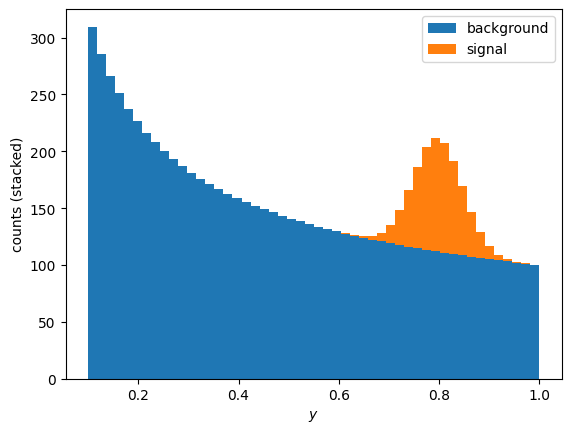

In [239]:
y_sample = np.linspace(0.1, 1, 100)  # Dependent variable

# Power-law background
x_b_sample = amp_b * (y_sample ** exp_b)  
amp_b=50
exp_b=-0.5

# Gaussian signal
x_s_sample = amp_s * np.exp(-((y_sample - mu_s) ** 2) / (2 * std_s ** 2))  
amp_s=50
mu_s=0.8
std_s=0.05

#Make stacked histogram to see distribution that you would be pulling from
plt.hist([y_sample, y_sample], bins=50, weights=[x_b_sample, x_s_sample], label=['background', 'signal'], stacked=True)

plt.legend()
plt.xlabel("$y$")
plt.ylabel("counts (stacked)")


In [240]:
#Make signal + background into one "forward model"
def bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b):
    """ Forward model for a Gaussian bump (amp_s, mu_s, std_s) on top 
    of a power-law background (amp_b, exp_b).
    """
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal

    x = x_b + x_s  # Total mean signal

    return x

def poisson_interval(k, alpha=0.32): 
    """ Uses chi2 to get the poisson interval.
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return k - low, high - k

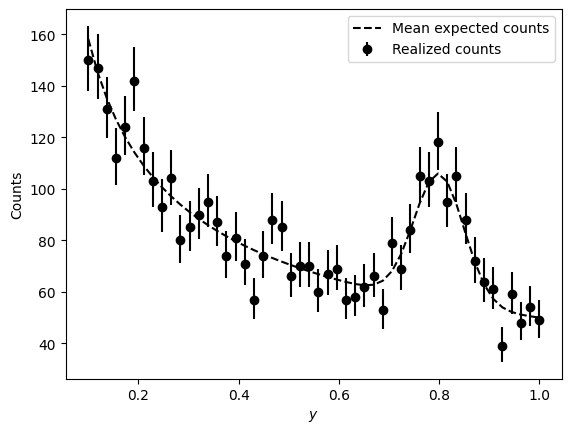

In [241]:
y = np.linspace(0.1, 1, 50)  # Dependent variable

# Mean expected counts
x_mu = bump_forward_model(y, 
                    amp_s=50, mu_s=0.8, std_s=0.05,  # Signal params
                    amp_b=50, exp_b=-0.5)  # Background params

# Realized counts
x = np.random.poisson(x_mu)
x_err = np.array([poisson_interval(k) for k in x.T]).T

# Plot
plt.plot(y, x_mu, color='k', ls='--', label="Mean expected counts")
plt.errorbar(y, x, yerr=x_err, fmt='o', color='k', label="Realized counts")

plt.xlabel("$y$")
plt.ylabel("Counts")

plt.legend()

# plt.savefig("assets/x1.pdf")

## 1.2 The explicit likelihood

In this case, we can write down a log-likelihood as a Poisson over the mean returned by the forward model.

In [119]:
def log_like(theta, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s, std_s) 
    on top of a power-law background (amp_b, exp_b).
    """
    amp_s, mu_s, std_s, amp_b, exp_b = theta
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

Let's focus on just 2 parameters for simplicity, the signal amplitude and mean location. The likelihood in this case is:

In [120]:
def log_like_sig(params, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = params
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

log_like_sig([50, 0.8], y, x)

-184.35695347969965

### Get a maximum-liklelihood estimate:

In [121]:
# Initial guess for the parameters
initial_guess = [100., 0.1]

# Set up the minimizer_kwargs for the basinhopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((0, 200), (0, 1))}

# Perform the optimization using basinhopping
opt = basinhopping(lambda thetas: -log_like_sig(thetas, y, x), initial_guess, minimizer_kwargs=minimizer_kwargs)

print("MLE parameters: {}; true parameters: {}".format(opt.x, (50, 0.8)))


MLE parameters: [48.81810568  0.7904376 ]; true parameters: (50, 0.8)


### And approximate posterior using `emcee`:

In [122]:
def log_prior(thetas):
    """ Log-prior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = thetas
    if 0 < amp_s < 200 and 0 < mu_s < 2:
        return 0
    else:
        return -np.inf
    
def log_post(thetas, y, x):
    """ Log-posterior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig(thetas, y, x)
    

In [128]:
# Sampling with `emcee`
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(y, x))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:20<00:00, 485.36it/s]


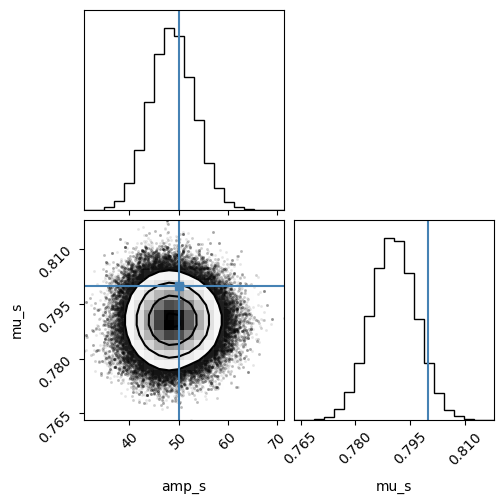

In [129]:
# Plot posterior samples
flat_samples = sampler.get_chain(discard=1000, flat=True) #"Burn in" or discrading the first X steps is common practice for MCMC
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], smooth=1.);

### Exercise: How does this change if you alter the number of walkers, sampling, burn-in, etc.? What if you use another MC method (https://chi-feng.github.io/mcmc-demo/)?

Hint: You will need to use a differnt package instead of emcee. Some options: pymc, pyhmc, tensorflow, pytorch

In [ ]:
# Sampling with `pyhmc`


## 1.3 The implicit likelihood

Now we will do inference without relying on the explicit likelihood evaluation. The key realization is that samples from the forward model implicitly encode the likelihood; when we are simulating data points $x$ for different parameter points $\theta$, we are drawing samples from the likelihood:
$$x\sim p(x\mid\theta)$$
which is where the _implicit_ aspect comes from. Let's write down a bump simulator:

In [151]:
def bump_simulator(thetas, y):
    """ Simulate samples from the bump forward model given theta = (amp_s, mu_s) and abscissa points y.
    """
    amp_s, mu_s = thetas
    std_s, amp_b, exp_b = 0.05, 100, -0.5
    x_mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    x = np.random.poisson(x_mu)
    settings = {"amp_s": amp_s, "mu_s": mu_s, "std_s": std_s, "amp_b": amp_b, "exp_b": exp_b}
    return x, settings

# Test it out
y = np.linspace(0.1, 1, 50)  # Dependent variable

x_simulated, setting_vals = bump_simulator([50, 0.8], y) #signal amp_s = 50, mu_s=0.8 
print(x_simulated)

[341 281 280 247 243 214 237 203 194 210 178 175 159 167 154 177 164 162
 168 128 146 155 156 138 143 137 118 136 121 133 121 122 125 135 136 113
 157 161 187 168 163 137 125 101 138 102  95 114  89 107]


### **Exercise:** Run the bump simulator multiple times. Notice that each time you run the cell above, the distribution changes. What makes the signal bump larger? What settings for the background makes your signal disappear? What moves the signal bump?

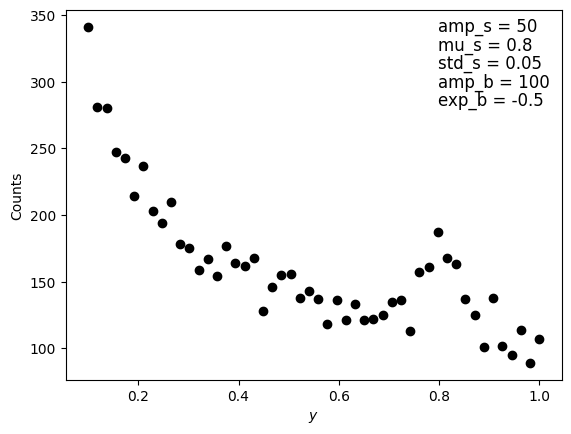

In [152]:
#Plot bump simulator
plt.plot(y,x_simulated,'ko')
plt.xlabel("$y$")
plt.ylabel("Counts")
for i, (name, value) in enumerate(setting_vals.items()):
    plt.text(0.75, 0.98 - i * 0.05, f"{name} = {value}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

## 1.4 Approximate Bayesian Computation (ABC)

<img src=./assets/abc.png alt= “” width=800>


The idea behind ABC is to simulate samples from the forward model (with the parameters $\theta$ drawn from a prior) and compare it to the dataset of interest $x$. If the data and realized samples are close enough to each other according to some criterion (such as Mean Squared Error), we keep the parameter points.

Downsides of vanilla ABC:
- How to summarize the data? Curse of dimensionality / loss of information.
- How to compare with data? Likelihood may not be available.
- Choice of acceptance threshold: Precision/efficiency tradeoff.
- Need to re-run pipeline for new data or new prior.

# 2. Neural likelihood-ratio estimation (NRE)

Let's replace the simulator in 

<img src=./assets/nre.png alt= “” width=1000>

For numerical stability, the alternate hypothesis $\theta_0$ can be assumed to be one where $x$ and $\theta$ are not correlated, i.e., drawn from the individual marginal distributions $\{x, \theta\} \sim p(x)\,p(\theta)$. Then the alternate has support over the entire parameter space, instead of being a single hypothesis $\theta_0$.

In this case, we get the likelihood-to-evidence ratio,

$$\hat r(x, \theta) = \frac{s(x, \theta)}{1 - s(x, \theta)} = \frac{p(x,\theta)}{p(x)p(\theta)} = \frac{p(x\mid\theta)}{p(x)}$$

$\hat r(x, \theta)$ can be shown to be the classifier logit, i.e. the output before softmaxxing into the decision function with range between 0 and 1.

Start by creating some training data.

In [154]:
n_train = 50_000

# Simulate training data
theta_samples = np.random.uniform(low=[0, 0], high=[200, 1], size=(n_train, 2))  # Parameter proposal
x_samples = np.array([bump_simulator(theta, y)[0] for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

100%|██████████| 50000/50000 [00:01<00:00, 38257.01it/s]


In [155]:
print(theta_samples.shape, x_samples.shape)

torch.Size([50000, 2]) torch.Size([50000, 50])


## 2.1. As our parameterized classifier, we will use a simple MLP.

In [157]:
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create an MLP from the configuration."""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

Create a neural ratio estimator class, with a corresponding loss function. The loss is a simple [binary cross-entropy loss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) that discriminates between samples from the joint distribution $\{x, \theta\} \sim p(x\mid\theta)$ and those from a product of marginals $\{x, \theta\} \sim p(x)\,p(\theta)$. Samples from the latter are obtained by shuffling joint samples from within a batch.

The binary cross-entropy loss is used as the classifier loss to distinguish samples from the joint and marginals,
$$\mathcal L = - \sum_i y_i \log(p_i)$$
where $y_i$ are the true labels and $p_i$ the softmaxxed probabilities.

In [158]:
class NeuralRatioEstimator(pl.LightningModule):
    """ Simple neural likelihood-to-evidence ratio estimator, using an MLP as a parameterized classifier.
    """
    def __init__(self, x_dim, theta_dim):
        super().__init__()
        self.classifier = build_mlp(input_dim=x_dim + theta_dim, hidden_dim=128, output_dim=1, layers=4)

    def forward(self, x):
        return self.classifier(x)
    
    def loss(self, x, theta):

        # Repeat x in groups of 2 along batch axis
        x = x.repeat_interleave(2, dim=0)

        # Get a shuffled version of theta
        theta_shuffled = theta[torch.randperm(theta.shape[0])]

        # Interleave theta and shuffled theta
        theta = torch.stack([theta, theta_shuffled], dim=1).reshape(-1, theta.shape[1])

        # Get labels; ones for pairs from joint, zeros for pairs from marginals
        labels = torch.ones(x.shape[0], device=x.device) 
        labels[1::2] = 0.0

        # Pass through parameterized classifier to get logits
        logits = self(torch.cat([x, theta], dim=1))
        probs = torch.sigmoid(logits).squeeze()

        return nn.BCELoss(reduction='none')(probs, labels)


    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [179]:
# Evaluate loss; initially it should be around -log(0.5) = 0.693
nre = NeuralRatioEstimator(x_dim=50, theta_dim=2)
initial_loss_array = nre.loss(x_samples[:64], theta_samples[:64])
print(initial_loss_array)

tensor([0.7026, 0.6838, 0.7044, 0.6822, 0.7041, 0.6823, 0.7017, 0.6847, 0.7049,
        0.6812, 0.7044, 0.6819, 0.7052, 0.6813, 0.7052, 0.6814, 0.7025, 0.6839,
        0.7043, 0.6818, 0.7054, 0.6811, 0.7063, 0.6801, 0.7061, 0.6803, 0.7031,
        0.6832, 0.7041, 0.6822, 0.7045, 0.6817, 0.7043, 0.6818, 0.7047, 0.6818,
        0.7034, 0.6831, 0.7037, 0.6825, 0.7036, 0.6830, 0.7043, 0.6822, 0.7049,
        0.6815, 0.7042, 0.6822, 0.7040, 0.6824, 0.7043, 0.6820, 0.7007, 0.6856,
        0.7049, 0.6820, 0.7050, 0.6814, 0.7037, 0.6829, 0.7013, 0.6853, 0.7039,
        0.6824, 0.7051, 0.6817, 0.7032, 0.6831, 0.7057, 0.6807, 0.7046, 0.6816,
        0.7043, 0.6821, 0.7066, 0.6798, 0.7040, 0.6825, 0.7050, 0.6812, 0.7044,
        0.6820, 0.7045, 0.6820, 0.7046, 0.6818, 0.7044, 0.6820, 0.7044, 0.6820,
        0.7044, 0.6819, 0.7048, 0.6819, 0.7050, 0.6815, 0.7047, 0.6817, 0.7047,
        0.6818, 0.7045, 0.6823, 0.7046, 0.6819, 0.7058, 0.6806, 0.7051, 0.6814,
        0.7051, 0.6812, 0.7052, 0.6812, 

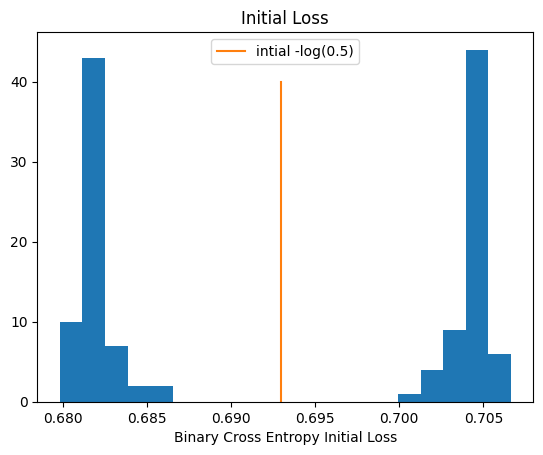

In [209]:
plt.hist(initial_loss_array.detach().numpy(),bins=20)
plt.plot([0.693,0.693],[0,40],label="intial -log(0.5)")
plt.xlabel("Binary Cross Entropy Initial Loss")
plt.title("Initial Loss")
plt.legend()

In [160]:
#Run dataloader
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


In [ ]:
#Train
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=nre, train_dataloaders=train_loader, val_dataloaders=val_loader);

The classifier logits are now an estimator for the likelihood ratio. We can write down a log-likelihood function and use it to sample from the corresponding posterior distribution, just like before.

In [191]:
def log_like(theta, x):
    """ Log-likelihood ratio estimator using trained classifier logits.
    """
        
    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std

    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)

    return nre.classifier(torch.cat([x, theta], dim=-1)).squeeze()

theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)[0]

log_like(theta_test, x_test)

tensor(-0.0233, grad_fn=<SqueezeBackward0>)

In [188]:
def log_post(theta, x):
    """ Log-posterior distribution, for sampling.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(theta, x).detach().numpy()

Sample with `emcee`:

In [190]:
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:23<00:00, 213.73it/s]


#### Plot approximate posterior:

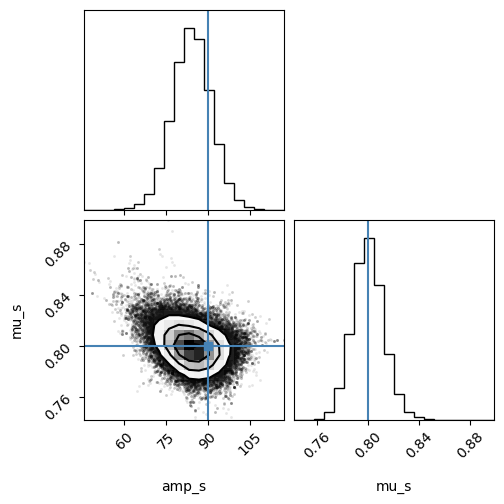

In [23]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

# 3. Neural posterior estimation (NPE)

<img src=./assets/npe.png alt= “” width=800>

#### Generic Neural Spline Flow in zuko

In [215]:
# Neural spline flow (NSF) with 3 sample features and 5 context features
flow = zuko.flows.NSF(3, 5, transforms=3, hidden_features=[128] * 3)

# Train to maximize the log-likelihood
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

for x, c in dataset_train:
    loss = -flow(c).log_prob(x)  # -log p(x | c)
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Sample 64 points x ~ p(x | c*)
x = flow(c_star).sample((64,))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x52 and 8x128)

In [213]:
import zuko

# Define the function to create the flow
def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """Instantiate a simple (Masked Autoregressive) normalizing flow using Zuko."""

    base_dist = zuko.distributions.DiagNormal(loc=0,scale=1,ndims=d_in)

    transforms = []
    for _ in range(n_layers):
        transforms.append(zuko.transforms.ReversePermutation(d_in))
        transforms.append(zuko.transforms.MaskedAffineAutoregressiveTransform(d_in, d_hidden, context_dim=d_context))
    
    transform = zuko.transforms.CompositeTransform(transforms)
    
    flow = zuko.flows.Flow(transform, base_dist)
    return flow

# Instantiate flow
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
context = torch.randn(2, 16)
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=context)
print(samples.shape, log_prob.shape)

ValueError: Expected reinterpreted_batch_ndims <= len(base_distribution.batch_shape), actual 2 vs 0

In [25]:
def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

# Instantiate flow
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
print(samples.shape, log_prob.shape)

torch.Size([2, 100, 2]) torch.Size([2, 100])


Construct a neural posterior estimator. It uses a normalizing flow as a (conditional) posterior density estimator, and a feature-extraction network that aligns the directions of variations in parameters $\theta$ and data $x$.
$$  \mathcal L = -\log p_\phi(\theta\mid s_\varphi(x))$$
where $\{\phi, \varphi\}$ are the parameters of the normalizing flow and featurizer MLP, respectively.

In [26]:
class NeuralPosteriorEstimator(pl.LightningModule):
    """ Simple neural posterior estimator class using a normalizing flow as the posterior density estimator.
    """
    def __init__(self, featurizer, d_context=16):
        super().__init__()
        self.featurizer = featurizer
        self.flow = get_flow(d_in=2, d_hidden=32, d_context=d_context, n_layers=4)

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        context = self(x)
        return -self.flow.log_prob(inputs=theta, context=context)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

Instantiate the NPE class and look at the loss:

In [27]:
npe = NeuralPosteriorEstimator(featurizer=build_mlp(input_dim=50, hidden_dim=128, output_dim=16, layers=4))
npe.loss(x_samples[:64], theta_samples[:64])

tensor([3.7843, 3.8738, 3.9518, 4.0794, 3.6791, 3.9817, 4.3857, 4.4798, 4.5228,
        4.7221, 3.6710, 4.4517, 4.2133, 3.9601, 4.4137, 4.6108, 3.9406, 4.7328,
        4.3728, 4.4590, 3.7482, 4.2472, 4.3484, 4.0043, 4.0342, 3.9290, 3.7566,
        4.2563, 4.4851, 4.3799, 4.2393, 3.7989, 4.3761, 4.1313, 3.9437, 4.2510,
        4.7588, 4.3307, 4.2605, 3.9174, 3.6827, 4.3489, 4.4073, 3.8204, 4.1285,
        4.5042, 4.6367, 4.4233, 3.8328, 4.8085, 4.4506, 4.7571, 3.7327, 4.0766,
        4.4962, 4.2689, 4.4157, 4.5896, 4.2844, 4.4578, 3.8447, 4.2823, 4.8359,
        4.1344], grad_fn=<NegBackward0>)

Train using the same data as before:

In [28]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | featurizer | Sequential | 74.6 K
1 | flow       | Flow       | 24.3 K
------------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

ERROR: Unexpected segmentation fault encountered in worker.
 

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Get a test data sample, pass it through the feature extractor, and condition the flow density estimator on it. We get posterior samples by drawing from 
$$\theta \sim p_\phi(\theta\mid s_\varphi(x)).$$

In [29]:
theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)

In [30]:
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm).unsqueeze(0)

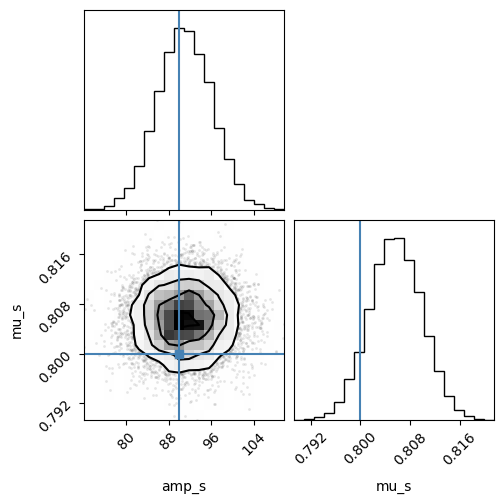

In [31]:
samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()
corner.corner(samples_test, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

# A more complicated example: distribution of point sources in a 2D image

Finally, let's look at a more complicated example, one that is closer to a typical application of SBI and where the likelihood is formally intractable.

The forward model simulates a map of point sources with mean counts drawn from a power law (Pareto) distribution. The distribution of the mean counts is given by the following equation:

$$
\frac{\mathrm dn}{\mathrm  ds} = A s^{\beta}
$$

where $A$ is the amplitude (amp_b), $s$ is the flux, and $\beta$ is the exponent (exp_b). The fluxes are drawn from a truncated power law with minimum and maximum bounds, $s_\text{min}$ and $s_\text{max}$, respectively.

The number of sources is determined by integrating the power law distribution within the flux limits and taking a Poisson realization:

$$
N_\text{sources} \sim \text{Pois}\left(\int_{s_\text{min}}^{s_\text{max}} \, \mathrm ds \frac{\mathrm dn}{\mathrm ds}\right)
$$

For each source, a position is randomly assigned within the box of size `box_size`. The fluxes are then binned into a grid with `resolution` number of bins in both x and y directions. The resulting map is convolved with a Gaussian point spread function (PSF) with a standard deviation of `sigma_psf` to account for the spatial resolution of the instrument.

The output is a 2D map of counts, representing the simulated observation of the point sources in the sky.

Text(0, 0.5, 'Pixels')

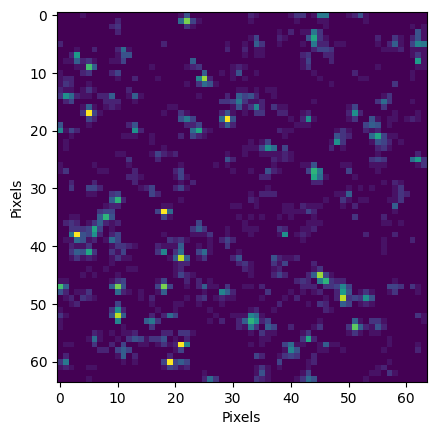

In [32]:
from scipy.stats import binned_statistic_2d
from astropy.convolution import convolve, Gaussian2DKernel


def simulate_sources(amp_b, exp_b, s_min=0.5, s_max=50.0, box_size=1., resolution=64, sigma_psf=0.01):
    """ Simulate a map of point sources with mean counts drawn from a power law (Pareto) distribution dn/ds = amp_b * s ** exp_b
    """
    # Get number of sources by analytically integrating dn/ds and taking Poisson realization
    n_sources = np.random.poisson(-amp_b * (s_min ** (exp_b - 1)) / (exp_b - 1))

    # Draw fluxes from truncated power law amp_b * s ** (exp_b - 1), with s_min and s_max as the bounds
    fluxes = draw_powerlaw_flux(n_sources, s_min, s_max, exp_b)

    positions = np.random.uniform(0., box_size, size=(n_sources, 2))
    bins = np.linspace(0, box_size, resolution + 1)

    pixel_size = box_size / resolution
    kernel = Gaussian2DKernel(x_stddev=1.0 * sigma_psf / pixel_size)

    mu_signal = binned_statistic_2d(x=positions[:, 0], y=positions[:, 1], values=fluxes, statistic='sum', bins=bins).statistic
    counts = np.random.poisson(convolve(mu_signal, kernel))
                
    return fluxes, counts

def draw_powerlaw_flux(n_sources, s_min, s_max, exp_b):
    """
    Draw from a powerlaw with slope `exp_b` and min/max mean counts `s_min` and `s_max`. From:
    https://stackoverflow.com/questions/31114330/python-generating-random-numbers-from-a-power-law-distribution
    """
    u = np.random.uniform(0, 1, size=n_sources)
    s_low_u, s_high_u = s_min ** (exp_b + 1), s_max ** (exp_b + 1)
    return (s_low_u + (s_high_u - s_low_u) * u) ** (1.0 / (exp_b + 1.0))

fluxes, counts = simulate_sources(amp_b=200., exp_b=-1.2)
plt.imshow(counts, cmap='viridis', vmax=20)
plt.xlabel("Pixels")
plt.ylabel("Pixels")

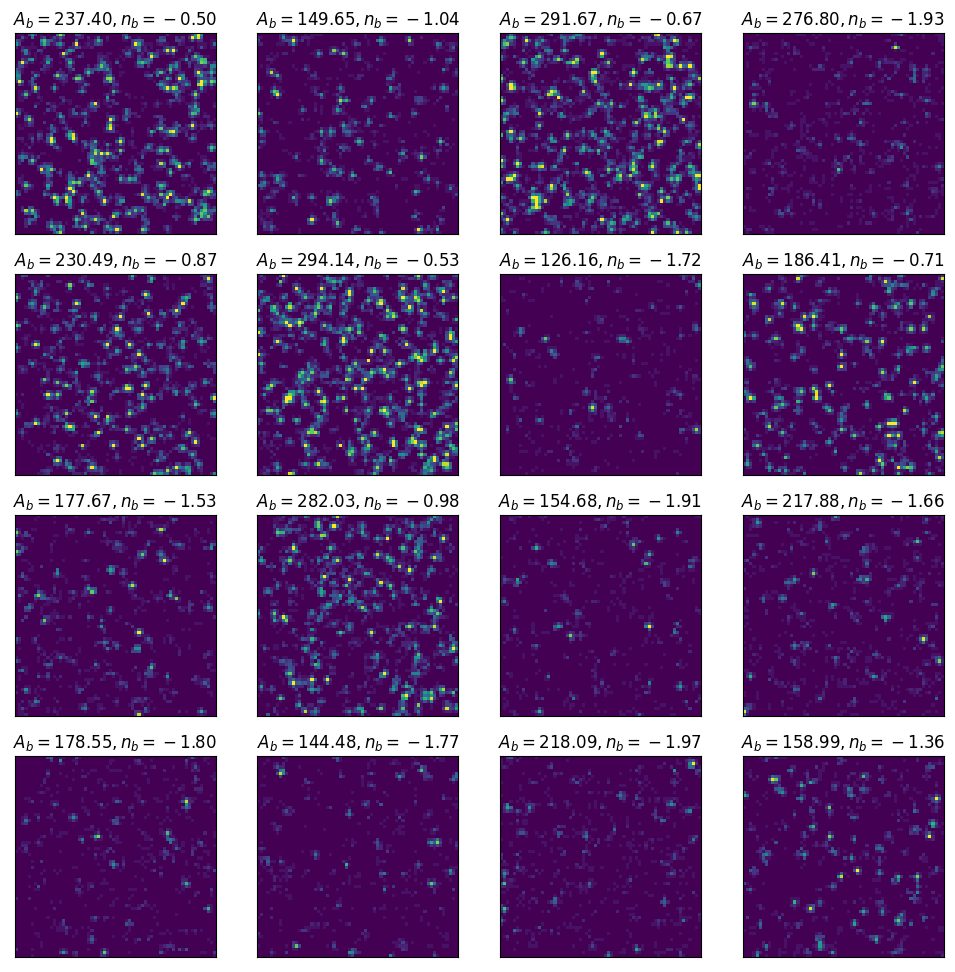

In [33]:
# Draw parameters from the prior
n_params = 16

amp_b_prior = (100., 300.)
exp_b_prior = (-2.0, -0.5)

amp_bs = np.random.uniform(amp_b_prior[0], amp_b_prior[1], n_params)
exp_bs = np.random.uniform(exp_b_prior[0], exp_b_prior[1], n_params)

# Plot the data samples on a grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    fluxes, counts = simulate_sources(amp_b=amp_bs[i], exp_b=exp_bs[i])
    im = ax.imshow(counts, cmap='viridis', vmax=20)
    ax.set_title(f'$A_b={amp_bs[i]:.2f}, n_b={exp_bs[i]:.2f}$')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Explicit likelihood

The (marginal) likelihood, which we would need to plug into something like MCMC, is computationally intractable! This is because it involves an integral over a cumbersome latent space, which consists of all possible number $n$ of sources and their positions $\{z\}=\{x, y\}_{i=1}^{n}$. Let's write this out formally:
$$p(x \mid \theta)=\sum_{n} \int \mathrm{d}^{n} \{z\}\, p\left(n \mid \theta\right) \prod_i^{n} p\left(z_{i} \mid \theta\right) \, p\left(x \mid \theta,\left\{z_{i}\right\}\right)$$

## Implicit inference: Neural posterior estimation

Let's use neural posterior estimation with a normalizing flow again. Get a training sample:

In [34]:
n_train = 30_000

# Sample from prior, then simulate
theta_samples = np.random.uniform(low=[10., -3.], high=[200., -0.99], size=(n_train, 2))
x_samples = np.array([simulate_sources(theta[0], theta[1])[1] for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.Tensor(theta_samples)
x_samples = torch.Tensor(x_samples)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std


100%|██████████| 30000/30000 [00:19<00:00, 1506.35it/s]


In [35]:
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


Since we're working with images, use a simple convolutional neural network (CNN) as the feature extractor. The normalizing flow will be conditioned on the output of the CNN.

In [36]:
class CNN(nn.Module):
    """ Simple CNN feature extractor.
    """
    def __init__(self, output_dim):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        
        x = x.unsqueeze(1)  # Add channel dim
        
        x = self.pool1(F.leaky_relu(self.conv1(x), negative_slope=0.02))
        x = self.pool2(F.leaky_relu(self.conv2(x), negative_slope=0.02))

        x = x.view(x.size(0), -1)

        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)

        return x

In [37]:
npe = NeuralPosteriorEstimator(featurizer=CNN(output_dim=32), d_context=32)
npe.loss(x_samples[:64], theta_samples[:64])

tensor([4.6032, 4.6815, 4.6393, 4.7667, 4.8952, 4.6751, 4.5814, 4.5703, 4.7069,
        4.6073, 4.6009, 4.5933, 4.5588, 4.7268, 4.6565, 4.6085, 4.6249, 4.5696,
        4.5533, 4.6116, 4.5951, 4.5671, 4.5492, 4.6952, 4.5614, 4.7098, 4.6358,
        4.6032, 4.6983, 4.5966, 4.5579, 4.8535, 4.6801, 4.6082, 4.5699, 4.7806,
        4.5955, 4.6414, 4.6073, 4.6327, 4.6385, 4.5838, 4.6477, 4.7587, 4.6138,
        4.5785, 4.5634, 4.6014, 4.5467, 4.6470, 4.5991, 4.5953, 4.5526, 4.5932,
        4.6120, 4.5714, 4.6183, 4.6632, 4.5355, 4.6438, 4.6128, 4.7842, 4.6496,
        4.6381], grad_fn=<NegBackward0>)

In [38]:
trainer = pl.Trainer(max_epochs=15)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type | Params
------------------------------------
0 | featurizer | CNN  | 265 K 
1 | flow       | Flow | 30.5 K
------------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.184     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [39]:
npe = npe.eval()

Get a test map, extract features, condition normalizing flow, extract samples.

In [40]:
params_test = np.array([15., -1.4])
x_test = simulate_sources(params_test[0], params_test[1])[1]

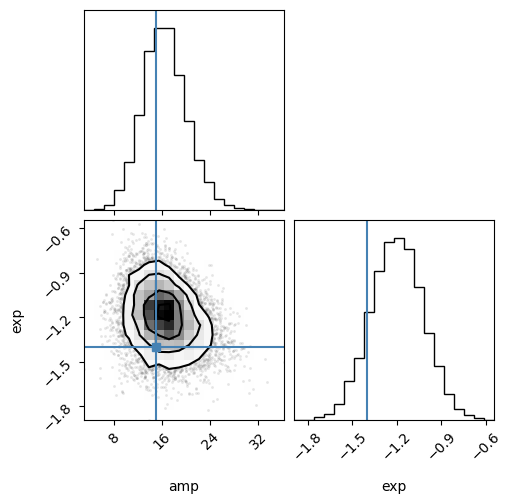

In [41]:
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm.unsqueeze(0))

samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

corner.corner(samples_test, labels=["amp", "exp"], truths=params_test);

## Test of statistical coverage

<img src=./assets/coverage.png alt= “” width=800>

Figure from 2209.01845.

We can do some checks to make sure that our posterior has the correct statistical interpretation. In particular, let's test the posterior statistical coverage by evaluating how well the Highest Posterior Density (HPD) intervals capture the true parameter values.

The **Highest Posterior Density (HPD)** interval is a region in the parameter space that contains the most probable values for a given credible mass (e.g., 95% or 99%). In other words, it is the shortest interval that contains the specified credible mass of the posterior distribution. This is one of summarizing a posterior distribution.

**Nominal coverage** is the probability, or the proportion of the parameter space, that the HPD interval is intended to contain. For example, if the nominal coverage is 0.95, the HPD interval should theoretically contain the true parameter value 95% of the time.

**Empirical coverage** is the proportion of true parameter values that actually fall within the HPD interval, based on a set of test cases or simulations.

For a perfectly calibrated posterior estimator, empirical coverage = nominal coverage for all credibility levels.

In [42]:
n_test = 200  # How many test samples to draw for coverage test

# Get samples 
x_test = torch.Tensor([simulate_sources(params_test[0], params_test[1])[1] for _ in range(n_test)])
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std

# and featurize
context = npe.featurizer(x_test_norm)

# Get posterior for all samples together in a batch
samples_test = npe.flow.sample(num_samples=1000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

/var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_9601/4001163492.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  x_test = torch.Tensor([simulate_sources(params_test[0], params_test[1])[1] for _ in range(n_test)])


In [43]:
def hpd(samples, credible_mass=0.95):
    """Compute highest posterior density (HPD) of array for given credible mass."""
    sorted_samples = np.sort(samples)
    interval_idx_inc = int(np.floor(credible_mass * sorted_samples.shape[0]))
    n_intervals = sorted_samples.shape[0] - interval_idx_inc
    interval_width = np.zeros(n_intervals)
    for i in range(n_intervals):
        interval_width[i] = sorted_samples[i + interval_idx_inc] - sorted_samples[i]
    hdi_min = sorted_samples[np.argmin(interval_width)]
    hdi_max = sorted_samples[np.argmin(interval_width) + interval_idx_inc]
    return hdi_min, hdi_max

hpd(samples_test[0, :, 0], credible_mass=0.2)

(18.008186, 19.924797)

In [44]:
p_nominals = np.linspace(0.01, 0.99, 50)
contains_true = np.zeros((2, n_test, len(p_nominals)))

for i_param in range(2):
    for i, sample in enumerate(samples_test[:, :, i_param]):
        for j, p_nominal in enumerate(p_nominals):
            hdi_min, hdi_max = hpd(sample, credible_mass=p_nominal)
            if hdi_min < params_test[i_param] < hdi_max:
                contains_true[i_param, i, j] = 1

Text(0.5, 1.0, 'Coverage for exponent')

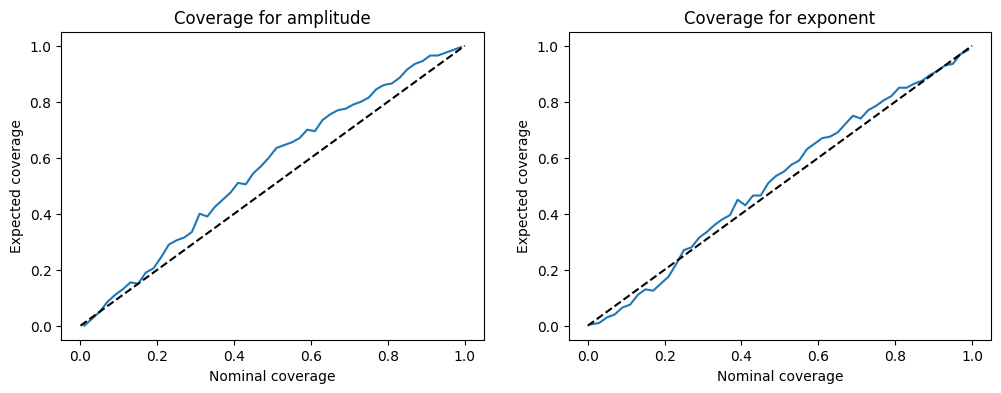

In [45]:
# Make two plots, one for each parameter

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(p_nominals, contains_true[0].sum(0) / n_test)
ax[0].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[0].set_xlabel("Nominal coverage")
ax[0].set_ylabel("Expected coverage")
ax[0].set_title("Coverage for amplitude")



ax[1].plot(p_nominals, contains_true[1].sum(0) / n_test)
ax[1].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[1].set_xlabel("Nominal coverage")
ax[1].set_ylabel("Expected coverage")
ax[1].set_title("Coverage for exponent")

# Further reading

- [The frontier of simulation-based inference](https://arxiv.org/abs/1911.01429) (Cranmer, Brehmer, Louppe): Review paper
- [simulation-based-inference.org](http://simulation-based-inference.org/): List of papers and resources
- [awesome-neural-sbi](https://github.com/smsharma/awesome-neural-sbi): List of papers and resources

<img src=./assets/header.png alt= “” width=800>
